In [2]:
import pandas as pd
import geopandas as gpd
import requests, json

Let's get the charger location data again:

In [3]:
apiKey = "eCN7llpPT79TmygqmvC71QdnnWdOquoRdnCR1DXo"
nrelString = "https://developer.nrel.gov/api/alt-fuel-stations/v1.geojson?api_key={}&fuel_type=ELEC&state=CA".format(apiKey)
chargers = gpd.read_file(nrelString)

In [4]:
chargers = chargers[chargers['access_code'] == 'public']

Now let's get EV sale data (this is on zip-code level):

In [7]:
sales = pd.read_csv("data/ZEV_Sales_by_Zipcode.csv")

In [14]:
zipSales = sales.groupby("ZIP").sum()

There are a couple zipcodes that aren't in CA that we need to drop: one is a random one with only one sale, and one (99999) seems to be used when there was no zipcode associated with the sale, so it's much larger than the other values. 
http://www.structnet.com/instructions/zip_min_max_by_state.html

In [18]:
zipSales = zipSales.drop(89061)
zipSales = zipSales.drop(99999)

In [20]:
#also, let's get rid of data year, bc it's not meaningful to us anymore; we just want total # of EV's sold
zipSales = zipSales.drop(columns = "Data Year")

In [23]:
zipSales['Number of Vehicles'].describe()

count    2162.000000
mean      519.116559
std       901.209629
min         1.000000
25%         6.000000
50%        67.000000
75%       706.500000
max      8123.000000
Name: Number of Vehicles, dtype: float64

Okay, now let's aggregate the charger locations by zipcode. We need to read in the zipcode boundaries:

In [62]:
zipcodes = gpd.read_file("data/Zipcode Boundaries/cb_2019_us_zcta510_500k.shp")

Now let's spatial join to count the number of chargers within each zip code:

In [64]:
joined_chargers = gpd.sjoin(chargers, zipcodes.to_crs("EPSG:4326"), predicate = "within", how = "left")

In [65]:
joined_chargers.head()

,access_code,access_days_time,access_detail_code,cards_accepted,date_last_confirmed,expected_date,fuel_type_code,groups_with_access_code,id,open_date,...,ev_pricing_fr,ev_network_ids,federal_agency,geometry,index_right,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10
2,public,24 hours daily; pay lot,None,None,2020-11-09,None,ELEC,Public,1523,1995-08-30,...,None,None,None,POINT (-118.27139 34.04054),26488.0,90015,8600000US90015,90015,4430399.0,0.0
10,public,24 hours daily,None,None,2021-10-12,None,ELEC,Public,1583,1996-10-15,...,None,None,None,POINT (-118.06400 34.06872),8696.0,91731,8600000US91731,91731,9881410.0,169467.0
12,public,24 hours daily,None,None,2021-07-14,None,ELEC,Public,6355,1997-07-30,...,None,None,None,POINT (-117.24300 32.89947),30854.0,92037,8600000US92037,92037,33842473.0,5226832.0
13,public,Dealership business hours,CALL,None,2021-12-09,None,ELEC,Public - Call ahead,6405,2012-12-11,...,None,None,None,POINT (-118.46837 34.22167),16093.0,91343,8600000US91343,91343,15310106.0,34625.0
14,public,6am-12am daily,None,None,2020-02-06,None,ELEC,Public,6425,1997-08-30,...,None,None,None,POINT (-117.45905 33.90991),31592.0,92503,8600000US92503,92503,77488367.0,10935445.0


In [69]:
group_chargers = joined_chargers.groupby("ZCTA5CE10").access_code.count()

In [74]:
group_chargers

ZCTA5CE10
21032     1
21043     1
90001     1
90002     6
90003     5
         ..
96146     2
96148     2
96150    22
96155     1
96161    23
Name: access_code, Length: 1126, dtype: int64

Again, there are some outside CA, so let's drop them:

In [73]:
group_chargers = group_chargers.drop('00987')

In [75]:
group_chargers = group_chargers.drop('21032')
group_chargers = group_chargers.drop('21043')

Okay, so now we should have the number of sales per zip code as well as the number of chargers.

In [76]:
zipSales

,Number of Vehicles
ZIP,
90001,168
90002,126
90003,124
90004,1576
90005,687
...,...
96151,2
96158,4
96160,8


In [79]:
group_chargers

ZCTA5CE10
90001     1
90002     6
90003     5
90004     3
90005     5
         ..
96146     2
96148     2
96150    22
96155     1
96161    23
Name: access_code, Length: 1124, dtype: int64

Some zipcodes have zero chargers, which means that they don't show up in the series, but we want them to, right? Anyways, we can join the two dataframes together to start plotting/comparing

In [81]:
joined_zipcodes = zipSales.join(group_chargers)
joined_zipcodes.head()

,Number of Vehicles,access_code
ZIP,,
90001,168,NaN
90002,126,NaN
90003,124,NaN
90004,1576,NaN
90005,687,NaN


In [87]:
#fix join
group_chargers.index = group_chargers.index.astype(int)
joined_zipcodes = zipSales.join(group_chargers)
joined_zipcodes.head(20)

,Number of Vehicles,access_code
ZIP,,
90001,168,1.0
90002,126,6.0
90003,124,5.0
90004,1576,3.0
90005,687,5.0
90006,435,4.0
90007,248,66.0
90008,645,5.0
90009,6,NaN


In [89]:
joined_zipcodes.rename(columns = {'access_code':'chargers'}, inplace = True)

In [102]:
#set nan to zero
joined_zipcodes.chargers = joined_zipcodes.chargers.fillna(0)

In [104]:
joined_zipcodes.head(10)

,Number of Vehicles,chargers
ZIP,,
90001,168,1.0
90002,126,6.0
90003,124,5.0
90004,1576,3.0
90005,687,5.0
90006,435,4.0
90007,248,66.0
90008,645,5.0
90009,6,0.0


Okay, we actually need the zipcode boundaries to plot as well lol

In [113]:
zipcodes['ZCTA5CE10'] = zipcodes['ZCTA5CE10'].astype(int)

In [114]:
zipcode_gdf = gpd.GeoDataFrame(joined_zipcodes, geometry = zipcodes.set_index("ZCTA5CE10").geometry)

OKAY NOW WE CAN PLOT

/Users/hfrahn/opt/anaconda3/envs/uds/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/hfrahn/opt/anaconda3/envs/uds/lib/python3.8/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

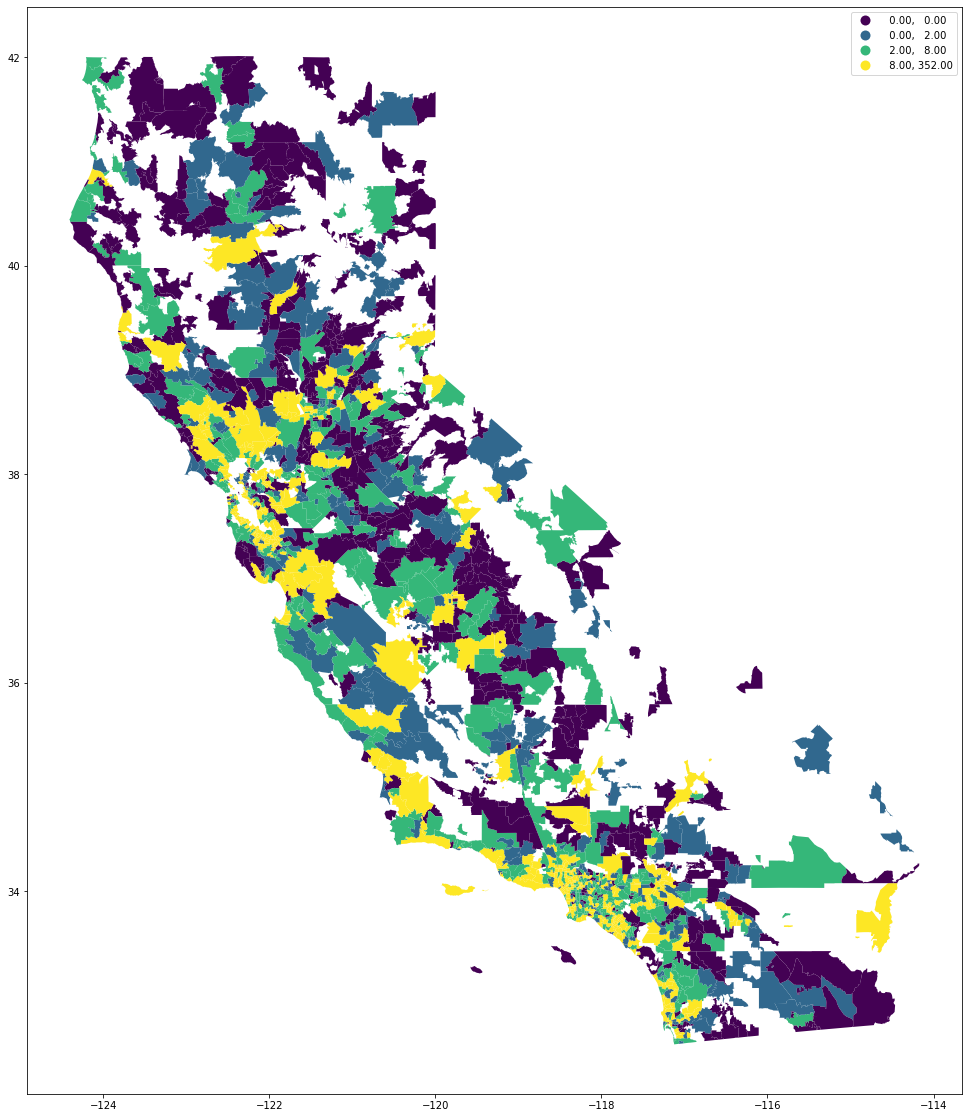

In [129]:
#fix this
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,20))
zipcode_gdf.plot(ax = ax,column = "chargers", legend = True, scheme = 'quantiles')

<AxesSubplot:>

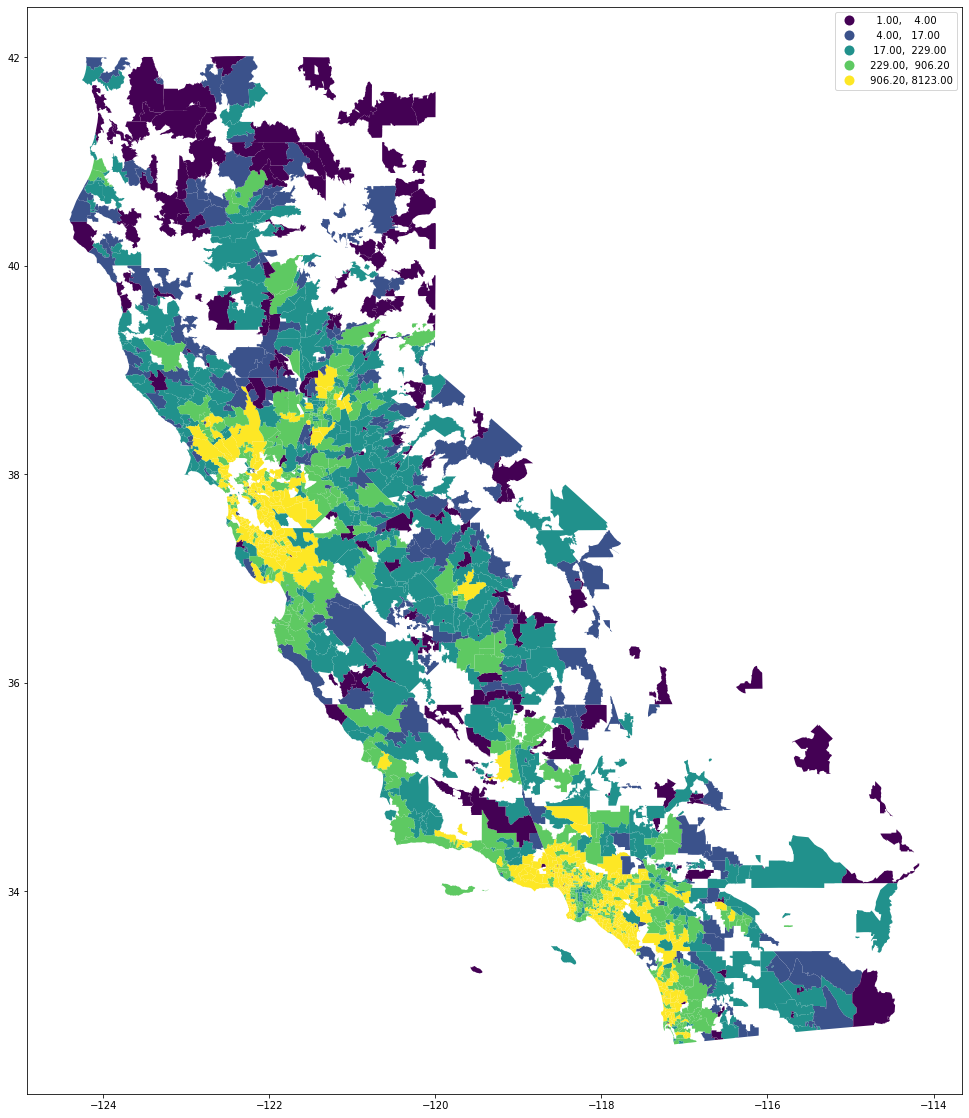

In [130]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,20))
zipcode_gdf.plot(ax = ax,column = "Number of Vehicles", legend = True, scheme = 'quantiles')